In [1]:
import pandas as pd
import numpy as np

# import pandasql as ps
# from pandasql import sqldf

import matplotlib.pyplot as plt
import seaborn as sns

import preprocess_functions
from preprocess_functions import *

import multiprocessing; cores = multiprocessing.cpu_count() # Count the number of cores in a computer

from textblob import Word
from nltk.corpus import stopwords


In [2]:
import gensim.models
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim import utils
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from gensim.parsing.preprocessing import remove_stopwords

In [3]:
from hdbscan import HDBSCAN
from bertopic import BERTopic

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import PCA


In [4]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

## Media dataframe (mdf)

In [5]:
tv = pd.read_csv("../TVTropesData/tv_tropes.csv")
tv["media"] = "tv"
film = pd.read_csv("../TVTropesData/film_tropes.csv")
film["media"] = "film"
lit = pd.read_csv("../TVTropesData/lit_tropes.csv")
lit["media"] = "lit"

mdf = pd.concat([tv, film, lit]).reset_index(drop=True)

In [6]:
mdf['Trope'] = clean_trope(mdf.Trope)
mdf = mdf.drop(columns="Unnamed: 0")

In [7]:
mdf.head(10)

,Title,Trope,Example,trope_id,title_id,media
0,ABitOfFryAndLaurie,page_three_stunna,This song from A Bit of Fry and Laurie descri...,t16579,tv0,tv
1,ABitOfFryAndLaurie,painful_rhyme,Played for humor as the entire basis of Hugh ...,t16587,tv0,tv
2,ABitOfFryAndLaurie,pocket_protector,Inverted nonsensically in the pilot of A Bit ...,t17280,tv0,tv
3,ABitOfFryAndLaurie,that_syncing_feeling,Played for laughs in a sketch in A Bit of Fry...,t22562,tv0,tv
4,ABitOfFryAndLaurie,literal_minded,NaN,t12979,tv0,tv
5,ABitOfFryAndLaurie,excuse_question,Parodied . Who was the first man to run the ...,t07222,tv0,tv
6,ABitOfFryAndLaurie,spy_speak,"A Bit of Fry and Laurie:\n In one sketch, a h...",t21241,tv0,tv
7,ABitOfFryAndLaurie,horror_host,Parodied by two skits in A Bit of Fry and Lau...,t10543,tv0,tv
8,ABitOfFryAndLaurie,freeze_frame_ending,A Bit of Fry and Laurie: Parodied in the pilo...,t08552,tv0,tv
9,ABitOfFryAndLaurie,false_reassurance,Stephen I think we'd better have a word wit...,t07587,tv0,tv


### Trope count

In [8]:
# Count number of appearances by media type
trope_count_media = mdf.groupby(['Trope','media'])['Trope'].count().unstack().fillna(0)

In [9]:
# Total count accross all 3
trope_count_media['total_count'] = trope_count_media['film']+ trope_count_media['lit'] +trope_count_media['tv']

In [10]:
# Order by total_count
trope_count_media = trope_count_media.sort_values(by='total_count', ascending=False)

trope_count_media = trope_count_media.reset_index()

In [11]:
trope_count_wide = trope_count_media

In [12]:
trope_count_wide.head(20)

media,Trope,film,lit,tv,total_count
0,shout_out,2091.0,1431.0,597.0,4119.0
1,big_bad,1229.0,953.0,234.0,2416.0
2,chekhovs_gun,1343.0,771.0,208.0,2322.0
3,deadpan_snarker,1043.0,711.0,424.0,2178.0
4,foreshadowing,1232.0,692.0,207.0,2131.0
5,meaningful_name,781.0,1103.0,242.0,2126.0
6,bittersweet_ending,1006.0,788.0,198.0,1992.0
7,horror_film,1972.0,18.0,0.0,1990.0
8,oh_crap,1340.0,421.0,200.0,1961.0
9,title_drop,936.0,570.0,184.0,1690.0


In [13]:
top20 = trope_count_wide[0:20]

In [14]:
# wide to long-ish
trope_count_media = (
pd.melt(trope_count_media, id_vars= ['Trope','total_count'])
    .sort_values(by=['total_count'], ascending=False)
    .reset_index(drop=True)
)

In [15]:
# Reorder columns 
trope_count_media = trope_count_media[['Trope','media','value','total_count']]

In [16]:
# Rename
trope_count_media = trope_count_media.rename(columns={'value':'count'})

# Top 20 Tropes

In [17]:
long20 = trope_count_media[trope_count_media.Trope.isin(top20.Trope)]

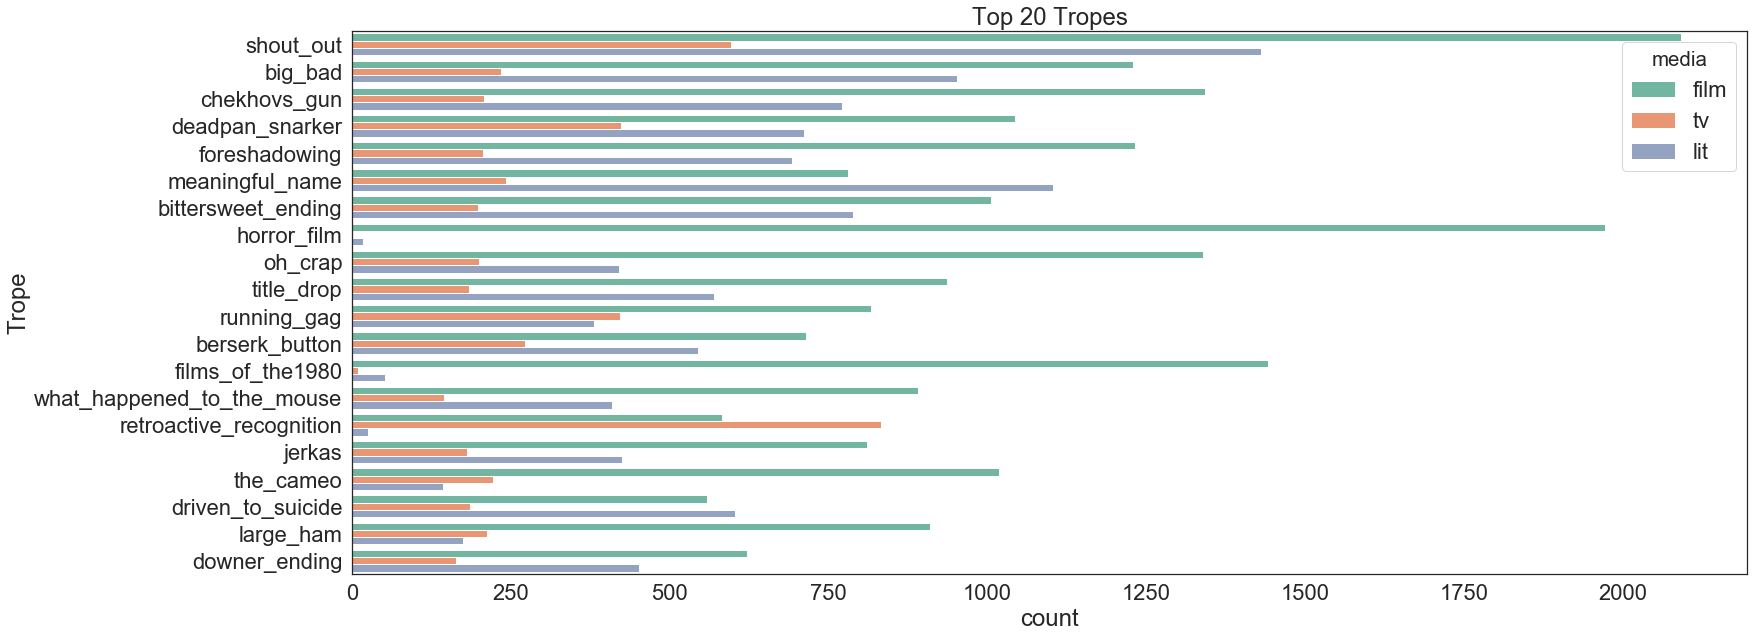

In [133]:
sns.set(rc={'figure.figsize':(25,10)}, style ='white', font_scale = 2)
sns.barplot(data=long20, y = 'Trope', x = 'count', hue = 'media', palette="Set2").set(title='Top 20 Tropes')
plt.savefig('../figs/top20.png',bbox_inches='tight')

## Trope dataframe (tdf)

In [23]:
tdf = pd.read_csv("../TVTropesData/tropes.csv")

In [24]:
# Clean Trope column
tdf['Trope'] = clean_trope(tdf.Trope)
tdf = tdf.drop(columns="Unnamed: 0")

In [25]:
tdf['clean_description'] = preprocess(tdf.Description)

100%|███████████████████████████████████| 30984/30984 [00:03<00:00, 9928.47it/s]


In [26]:
tdf.head(10)

,TropeID,Trope,Description,clean_description
0,t00001,abandoned_area,\nAbandoned places make good settings for fict...,abandoned places make good settings for fictio...
1,t00002,abandoned_catchphrase,Catchphrases are a great and simple way to hel...,catchphrases are a great and simple way to hel...
2,t00003,abandoned_hospital,The creepy abandoned hospital/mental instituti...,the creepy abandoned hospital mental instituti...
3,t00004,abandoned_hospital_awakening,"An Abandoned Hospital Awakening is, as the nam...",an abandoned hospital awakening is as the name...
4,t00005,abandoned_info_page,When a work is getting more and more complicat...,when a work is getting more and more complicat...
5,t00006,abandoned_laboratory,The Abandoned Laboratory is a common setting i...,the abandoned laboratory is a common setting i...
6,t00007,abandoned_mascot,Series Mascots are usually consistent for deca...,series mascots are usually consistent for deca...
7,t00008,abandoned_mine,Maybe there's nothing left to mine. Maybe it w...,maybe there is nothing left to mine maybe it w...
8,t00009,abandoned_pet_in_a_box,"\nIn many works of fiction, there comes a time...",in many works of fiction there comes a time wh...
9,t00010,abandoned_playground,\nThere's just something about the image of a ...,there is just something about the image of a p...


## Facts about data

In [27]:
# Unique trope
tdf.Trope.nunique()

30734

### Unique works

In [80]:
# Unique works
n_title = mdf.groupby(["media"])["Title"].nunique().reset_index()
n_title

,media,Title
0,film,17019
1,lit,15495
2,tv,7921


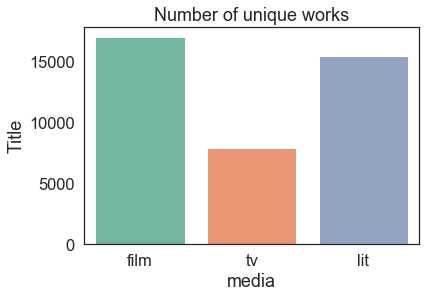

In [132]:
sns.set(rc={'figure.figsize':(6,4)}, style ='white', font_scale = 1.5)
sns.barplot(data =n_title, x = 'media', y= 'Title', order=['film','tv','lit'], palette='Set2').set(title = 'Number of unique works')
plt.savefig('../figs/n_title.png',bbox_inches='tight')

### Top works

In [97]:
top_works = mdf.groupby(["Title","media"])["Trope"].size().reset_index().sort_values(by="Trope", ascending=False)

In [118]:
top_tv = top_works[top_works.media == "tv"].sort_values(by="Trope", ascending=False)[0:10]


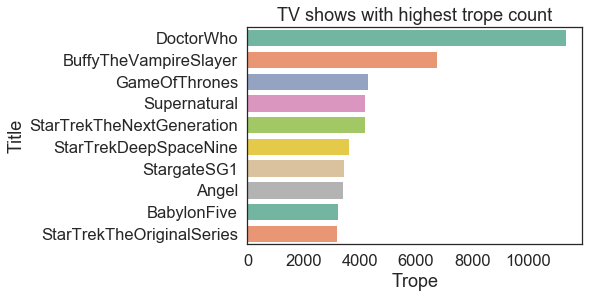

In [131]:
sns.set(rc={'figure.figsize':(6,4)}, style ='white', font_scale = 1.5)
sns.barplot(data = top_tv, y = "Title", x = "Trope", palette= 'Set2').set(title = "TV shows with highest trope count")
plt.savefig('../figs/tv_top10.png',bbox_inches='tight')

In [119]:
top_lit = top_works[top_works.media == "lit"].sort_values(by="Trope", ascending=False)[0:10]
top_lit.head(10)

,Title,media,Trope
7790,Discworld,lit,6904
12226,HarryPotter,lit,5077
29922,TheDresdenFiles,lit,3734
506,ASongOfIceAndFire,lit,3704
28354,TheBible,lit,3033
32543,TheLordOfTheRings,lit,2889
39247,WhateleyUniverse,lit,2546
9632,FateStayNight,lit,2389
1778,Animorphs,lit,2235
36259,TheWheelOfTime,lit,2143


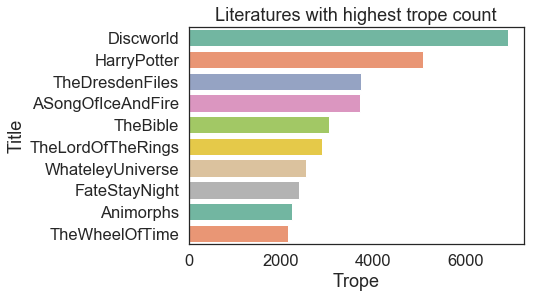

In [130]:
sns.set(rc={'figure.figsize':(6,4)}, style ='white', font_scale = 1.5)
sns.barplot(data = top_lit, y = "Title", x = "Trope", palette= 'Set2').set(title = "Literatures with highest trope count")
plt.savefig('../figs/lit_top10.png', bbox_inches='tight')

In [122]:
top_film = top_works[top_works.media == "film"].sort_values(by="Trope", ascending=False)[0:10]
top_film.head(10)

,Title,media,Trope
14536,JamesBond,film,2633
32919,TheMatrix,film,1776
29546,TheDarkKnight,film,1692
378,ANewHope,film,1565
32542,TheLordOfTheRings,film,1477
2380,AvengersEndgame,film,1465
26196,StarTrek2009,film,1461
28143,TheAvengers2012,film,1433
23025,ReturnOfTheJedi,film,1431
36835,Thor,film,1410


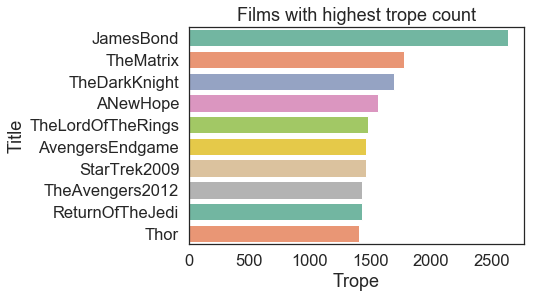

In [129]:
sns.set(rc={'figure.figsize':(6,4)}, style ='white', font_scale = 1.5)
sns.barplot(data = top_film, y = "Title", x = "Trope", palette= 'Set2').set(title = "Films with highest trope count")
plt.savefig('../figs/film_top10.png', bbox_inches='tight')

### Word2Vec

In [ ]:
sentences = [row.lower().split() for row in tdf["clean_description"]]

In [ ]:
# singularize
for i in range(len(sentences)):
    sentences[i] = [word for word in sentences[i] if word not in stopwords.words('english')]
#     sentences[i] = [Word(w).singularize() for w in sentences[i]]

In [ ]:
# Train a toy phrase model on our training corpus.
phrase_model = Phrases(sentences, min_count=2, connector_words=ENGLISH_CONNECTOR_WORDS)

In [ ]:
bigram_no_sw = Word2Vec(phrase_model[sentences],
                  min_count=2,
                  window=5,
                  vector_size=100,
                  workers=cores-1,
                  epochs=30,
                  seed=42)

In [ ]:
unigram_no_sw = Word2Vec(sentences,
                   min_count=5,
                   window=5,
                   vector_size=100,
                   workers=cores-1,
                   epochs=30,
                   seed=42)

### Save word vectors

In [ ]:
# bigram_no_sw.wv.save_word2vec_format("../models/bigram_word2vec_no_sw")
# unigram_no_sw.wv.save_word2vec_format("../models/unigram_word2vec_no_sw")

### Save models

In [ ]:
bigram_no_sw.save("../models/bigram_word2vec_no_sw.model")
unigram_no_sw.save("../models/unigram_word2vec_no_sw.model")

In [ ]:
bigram.wv.most_similar(positive=['love_interest'])

In [ ]:
bigram.wv.similarity('villain','girl')

#### Convert to tensor

In [ ]:
# Run in terminal:
# python -m gensim.scripts.word2vec2tensor -i models/unigram_word2vec -o tensors/unigram
# python -m gensim.scripts.word2vec2tensor -i models/bigram_word2vec -o tensors/bigram

### Load

In [137]:
bigram = Word2Vec.load("../models/bigram_word2vec.model")

In [138]:
bigram.wv.most_similar('big_bad')

[('bad_guy', 0.7065610885620117),
 ('villain', 0.7063288688659668),
 ('defeated', 0.6340667009353638),
 ('hero', 0.6219871044158936),
 ('antagonist', 0.6172733902931213),
 ('rival', 0.61487877368927),
 ('dragon', 0.6147741079330444),
 ('good_guys', 0.6119282245635986),
 ('minion', 0.6085368990898132),
 ('good_guy', 0.5965617299079895)]

In [139]:
bigram.wv.most_similar('dragon')

[('lancer', 0.6604410409927368),
 ('wolf', 0.6275288462638855),
 ('squad', 0.6199926137924194),
 ('wannabe', 0.6189258694648743),
 ('big_bad', 0.6147741079330444),
 ('knight', 0.5930625200271606),
 ('rival', 0.5887823104858398),
 ('minion', 0.5824518203735352),
 ('big_guy', 0.5746404528617859),
 ('demon', 0.573767364025116)]

In [143]:
bigram.wv.most_similar('immovable_object')

[('unstoppable_force', 0.7879235744476318),
 ('antechamber', 0.7867285013198853),
 ('axe_to_grind', 0.784503161907196),
 ('alcoholic_drink', 0.7821184992790222),
 ('unusable_weapon', 0.7817029356956482),
 ('enclave', 0.7776504755020142),
 ('ant', 0.7769170999526978),
 ('automated_weapon', 0.7734383940696716),
 ('evolutionary_strategy', 0.771808385848999),
 ('adjunct', 0.7712868452072144)]